<h1 align="center"> Forecasting Electricity Prices Using LSTM-Based Time Series Analysis </h1>


In [392]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# import tensorflow as tf
# import tensorflow_addons as tfa


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from keras import Sequential
from keras import layers
from keras.models import Model
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Flatten, Conv1D
from keras.layers import MaxPooling1D, GRU, Input,Masking, Concatenate, dot
from keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

# **Data Collection & Exploration **

In [393]:
# loading energy data
df_energy = pd.read_csv('/kaggle/input/mydataset/energy_dataset.csv')
df_energy.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

Many features contain mostly 0 or NaN values, so we will remove these columns.

Additionally, the day-ahead forecasting columns will be removed.

In [394]:
df_energy.describe().T

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



count          mean  \
generation biomass                           35045.0    383.513540   
generation fossil brown coal/lignite         35046.0    448.059208   
generation fossil coal-derived gas           35046.0      0.000000   
generation fossil gas                        35046.0   5622.737488   
generation fossil hard coal                  35046.0   4256.065742   
generation fossil oil                        35045.0    298.319789   
generation fossil oil shale                  35046.0      0.000000   
generation fossil peat                       35046.0      0.000000   
generation geothermal                        35046.0      0.000000   
generation hydro pumped storage aggregated       0.0           NaN   
generation hydro pumped storage consumption  35045.0    475.577343   
generation hydro run-of-river and poundage   35045.0    972.116108   
generation hydro water reservoir             35046.0   2605.114735   
generation marine                            35045.0      0.000000   
generation nuclear                           35047.0   6263.907039   
generation other                             35046.0     60.228585   
generation other renewable                   35046.0     85.639702   
generation solar                             35046.0   1432.665925   
generation waste                             35045.0    269.452133   
generation wind offshore                     35046.0      0.000000   
generation wind onshore                      35046.0   5464.479769   
forecast solar day ahead                     35064.0   1439.066735   
forecast wind offshore eday ahead                0.0           NaN   
forecast wind onshore day ahead              35064.0   5471.216689   
total load forecast                          35064.0  28712.129962   
total load actual                            35028.0  28696.939905   
price day ahead                              35064.0     49.874341   
price actual                                 35064.0     57.884023   

                                                     std       min  \
generation biomass                             85.353943      0.00   
generation fossil brown coal/lignite          354.568590      0.00   
generation fossil coal-derived gas              0.000000      0.00   
generation fossil gas                        2201.830478      0.00   
generation fossil hard coal                  1961.601013      0.00   
generation fossil oil                          52.520673      0.00   
generation fossil oil shale                     0.000000      0.00   
generation fossil peat                          0.000000      0.00   
generation geothermal                           0.000000      0.00   
generation hydro pumped storage aggregated           NaN       NaN   
generation hydro pumped storage consumption   792.406614      0.00   
generation hydro run-of-river and poundage    400.777536      0.00   
generation hydro water reservoir             1835.199745      0.00   
generation marine                               0.000000      0.00   
generation nuclear                            839.667958      0.00   
generation other                               20.238381      0.00   
generation other renewable                     14.077554      0.00   
generation solar                             1680.119887      0.00   
generation waste                               50.195536      0.00   
generation wind offshore                        0.000000      0.00   
generation wind onshore                      3213.691587      0.00   
forecast solar day ahead                     1677.703355      0.00   
forecast wind offshore eday ahead                    NaN       NaN   
forecast wind onshore day ahead              3176.312853    237.00   
total load forecast                          4594.100854  18105.00   
total load actual                            4574.987950  18041.00   
price day ahead                                14.618900      2.06   
price actual                                   14.204083

In [395]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [396]:
# columns to be removed due to all 0 or Nan values
col_names = ['generation fossil coal-derived gas', 'generation fossil oil shale','generation fossil peat',
           'generation geothermal', 'generation hydro pumped storage aggregated', 'generation marine',
           'generation wind offshore', 'forecast wind offshore eday ahead', 'forecast solar day ahead',
            'forecast wind onshore day ahead']

In [397]:
df_energy = df_energy.drop(col_names, axis = 1)

In [398]:
# Checking Nans and duplicates in each columns
def check_Nans_Dups(df_input):

    print('Number of Nans in each column :')

    print(df_input.isnull().sum())
    print()
    print(f'Number of duplicates in the dataframe : {df_input.duplicated().sum()}')
    return

In [399]:
check_Nans_Dups(df_energy)

Number of Nans in each column :
time                                            0
generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load forecast                             0
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

Numb

In [400]:
df_energy['time'] = pd.to_datetime(df_energy['time'])
df_energy = df_energy.set_index('time')
df_energy

/tmp/ipykernel_48/980508139.py:1: FutureWarning:

In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`



generation biomass  \
time                                            
2015-01-01 00:00:00+01:00               447.0   
2015-01-01 01:00:00+01:00               449.0   
2015-01-01 02:00:00+01:00               448.0   
2015-01-01 03:00:00+01:00               438.0   
2015-01-01 04:00:00+01:00               428.0   
...                                       ...   
2018-12-31 19:00:00+01:00               297.0   
2018-12-31 20:00:00+01:00               296.0   
2018-12-31 21:00:00+01:00               292.0   
2018-12-31 22:00:00+01:00               293.0   
2018-12-31 23:00:00+01:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-01 00:00:00+01:00                                 329.0   
2015-01-01 01:00:00+01:00                                 328.0   
2015-01-01 02:00:00+01:00                                 323.0   
2015-01-01 03:00:00+01:00                                 254.0   
2015-01-01 04:00:00+01:00                                 187.0   
...                                                         ...   
2018-12-31 19:00:00+01:00                                   0.0   
2018-12-31 20:00:00+01:00                                   0.0   
2018-12-31 21:00:00+01:00                                   0.0   
2018-12-31 22:00:00+01:00                                   0.0   
2018-12-31 23:00:00+01:00                                   0.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2015-01-01 00:00:00+01:00                 4844.0                       4821.0   
2015-01-01 01:00:00+01:00                 5196.0                       4755.0   
2015-01-01 02:00:00+01:00                 4857.0                       4581.0   
2015-01-01 03:00:00+01:00                 4314.0                       4131.0   
2015-01-01 04:00:00+01:00                 4130.0                       3840.0   
...                                          ...                          ...   
2018-12-31 19:00:00+01:00                 7634.0                       2628.0   
2018-12-31 20:00:00+01:00                 7241.0                       2566.0   
2018-12-31 21:00:00+01:00                 7025.0                       2422.0   
2018-12-31 22:00:00+01:00                 6562.0                       2293.0   
2018-12-31 23:00:00+01:00                 6926.0                       2166.0   

                           generation fossil oil  \
time                                               
2015-01-01 00:00:00+01:00                  162.0   
2015-01-01 01:00:00+01:00                  158.0   
2015-01-01 02:00:00+01:00                  157.0   
2015-01-01 03:00:00+01:00                  160.0   
2015-01-01 04:00:00+01:00                  156.0   
...                                          ...   
2018-12-31 19:00:00+01:00                  178.0   
2018-12-31 20:00:00+01:00                  174.0   
2018-12-31 21:00:00+01:00                  168.0   
2018-12-31 22:00:00+01:00                  163.0   
2018-12-31 23:00:00+01:00                  163.0   

                           generation hydro pumped storage consumption  \
time                                                                     
2015-01-01 00:00:00+01:00                                        863.0   
2015-01-01 01:00:00+01:00                                        920.0   
2015-01-01 02:00:00+01:00                                       1164.0   
2015-01-01 03:00:00+01:00                                       1503.0   
2015-01-01 04:00:00+01:00                                       1826.0   
...                                                                ...   
2018-12-31 19:00:00+01:00                                          1.0   
2018-12-31 20:00:00+01:00                                          1.0   
2018-12-31 21:00:00+01:00                     

Text(0, 0.5, 'total load actual')

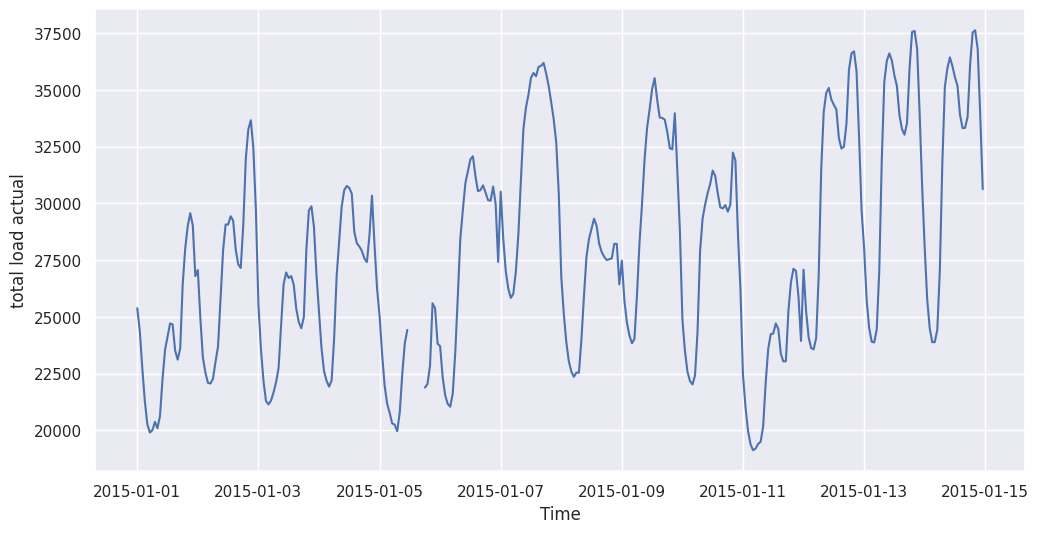

In [401]:
plt.figure(figsize=(12,6))
# plot total load actual for two weeks duration
plt.plot(df_energy['total load actual'][:24*7*2])
plt.xlabel('Time')
plt.ylabel('total load actual')

**The dataframe has few NaN values. Since the missing values are limited and the time series is regular, we will use linear interpolation to estimate them. Large or irregular gaps would be better removed to avoid bias.**

In [402]:
df_energy[df_energy.isna().any(axis = 1)]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



generation biomass  \
time                                            
2015-01-05 03:00:00+01:00                 NaN   
2015-01-05 12:00:00+01:00                 NaN   
2015-01-05 13:00:00+01:00                 NaN   
2015-01-05 14:00:00+01:00                 NaN   
2015-01-05 15:00:00+01:00                 NaN   
2015-01-05 16:00:00+01:00                 NaN   
2015-01-05 17:00:00+01:00                 NaN   
2015-01-19 19:00:00+01:00                 NaN   
2015-01-19 20:00:00+01:00                 NaN   
2015-01-27 19:00:00+01:00                 NaN   
2015-01-28 13:00:00+01:00                 NaN   
2015-02-01 07:00:00+01:00               449.0   
2015-02-01 08:00:00+01:00               453.0   
2015-02-01 09:00:00+01:00               452.0   
2015-02-01 12:00:00+01:00               405.0   
2015-02-01 13:00:00+01:00               402.0   
2015-02-01 14:00:00+01:00               400.0   
2015-02-01 15:00:00+01:00               393.0   
2015-02-01 16:00:00+01:00               413.0   
2015-02-01 17:00:00+01:00               465.0   
2015-02-01 18:00:00+01:00               482.0   
2015-02-01 19:00:00+01:00               474.0   
2015-04-05 03:00:00+02:00               371.0   
2015-04-16 09:00:00+02:00                 NaN   
2015-04-20 08:00:00+02:00               424.0   
2015-04-23 21:00:00+02:00                 NaN   
2015-05-02 10:00:00+02:00               497.0   
2015-05-29 03:00:00+02:00               569.0   
2015-06-15 09:00:00+02:00                 NaN   
2015-10-02 08:00:00+02:00               483.0   
2015-10-02 11:00:00+02:00                 NaN   
2015-12-02 09:00:00+01:00                 NaN   
2016-04-13 05:00:00+02:00               220.0   
2016-04-25 05:00:00+02:00               190.0   
2016-04-25 07:00:00+02:00               206.0   
2016-05-10 23:00:00+02:00               348.0   
2016-06-12 01:00:00+02:00               356.0   
2016-07-09 22:00:00+02:00                 NaN   
2016-07-12 00:00:00+02:00               346.0   
2016-09-28 09:00:00+02:00               347.0   
2016-10-27 23:00:00+02:00               351.0   
2016-11-23 04:00:00+01:00                 NaN   
2017-11-14 12:00:00+01:00                 0.0   
2017-11-14 19:00:00+01:00                 0.0   
2018-06-11 18:00:00+02:00               331.0   
2018-07-11 09:00:00+02:00                 NaN   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-05 03:00:00+01:00                                   NaN   
2015-01-05 12:00:00+01:00                                   NaN   
2015-01-05 13:00:00+01:00                                   NaN   
2015-01-05 14:00:00+01:00                                   NaN   
2015-01-05 15:00:00+01:00                                   NaN   
2015-01-05 16:00:00+01:00                                   NaN   
2015-01-05 17:00:00+01:00                                   NaN   
2015-01-19 19:00:00+01:00                                   NaN   
2015-01-19 20:00:00+01:00                                   NaN   
2015-01-27 19:00:00+01:00                                   NaN   
2015-01-28 13:00:00+01:00                                   NaN   
2015-02-01 07:00:00+01:00                                 312.0   
2015-02-01 08:00:00+01:00                                 312.0   
2015-02-01 09:00:00+01:00                                 302.0   
2015-02-01 12:00:00+01:00                                 317.0   
2015-02-01 13:00:00+01:00                                 317.0   
2015-02-01 14:00:00+01:00                                 317.0   
2015-02-01 15:00:00+01:00                                 321.0   
2015-02-01 16:00:00+01:00                                 325.0   
2015-02-01 17:00:00+01:00                                 321.0   
2015-02-01 18:00:00+01:00                                 326.0   
2015-02-01 19:00:00+01:00                                 326.0   
2015-04-05 03:00:00+02:00                                   0.0   

In [403]:
df_energy.interpolate(method='linear', limit_direction='forward', inplace = True)
df_energy.isnull().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

**<strong> Feature Correlation </strong>**

Based on feature correlation,**“generation fossil hard coal”** and **“generation fossil brown coal/lignite”** are highly correlated. We will combine them into a single feature, “generation fossil total,” and remove the originals.

Note: Total load forecasting and total load actual are also highly correlated. We will keep the forecasting column for visualization purposes, but it will be dropped before modeling.

In [404]:
def feat_corr(input_df):
    # Keep only numeric columns for correlation
    numeric_df = input_df.select_dtypes(include=['number'])
    
    plt.figure(figsize=(15, 12))
    corr = numeric_df.corr()
    
    sns.heatmap(corr, annot=True, cmap="RdYlGn", vmin=-1, vmax=1)
    plt.title("Feature Correlation Heatmap", fontsize=16)
    plt.show()


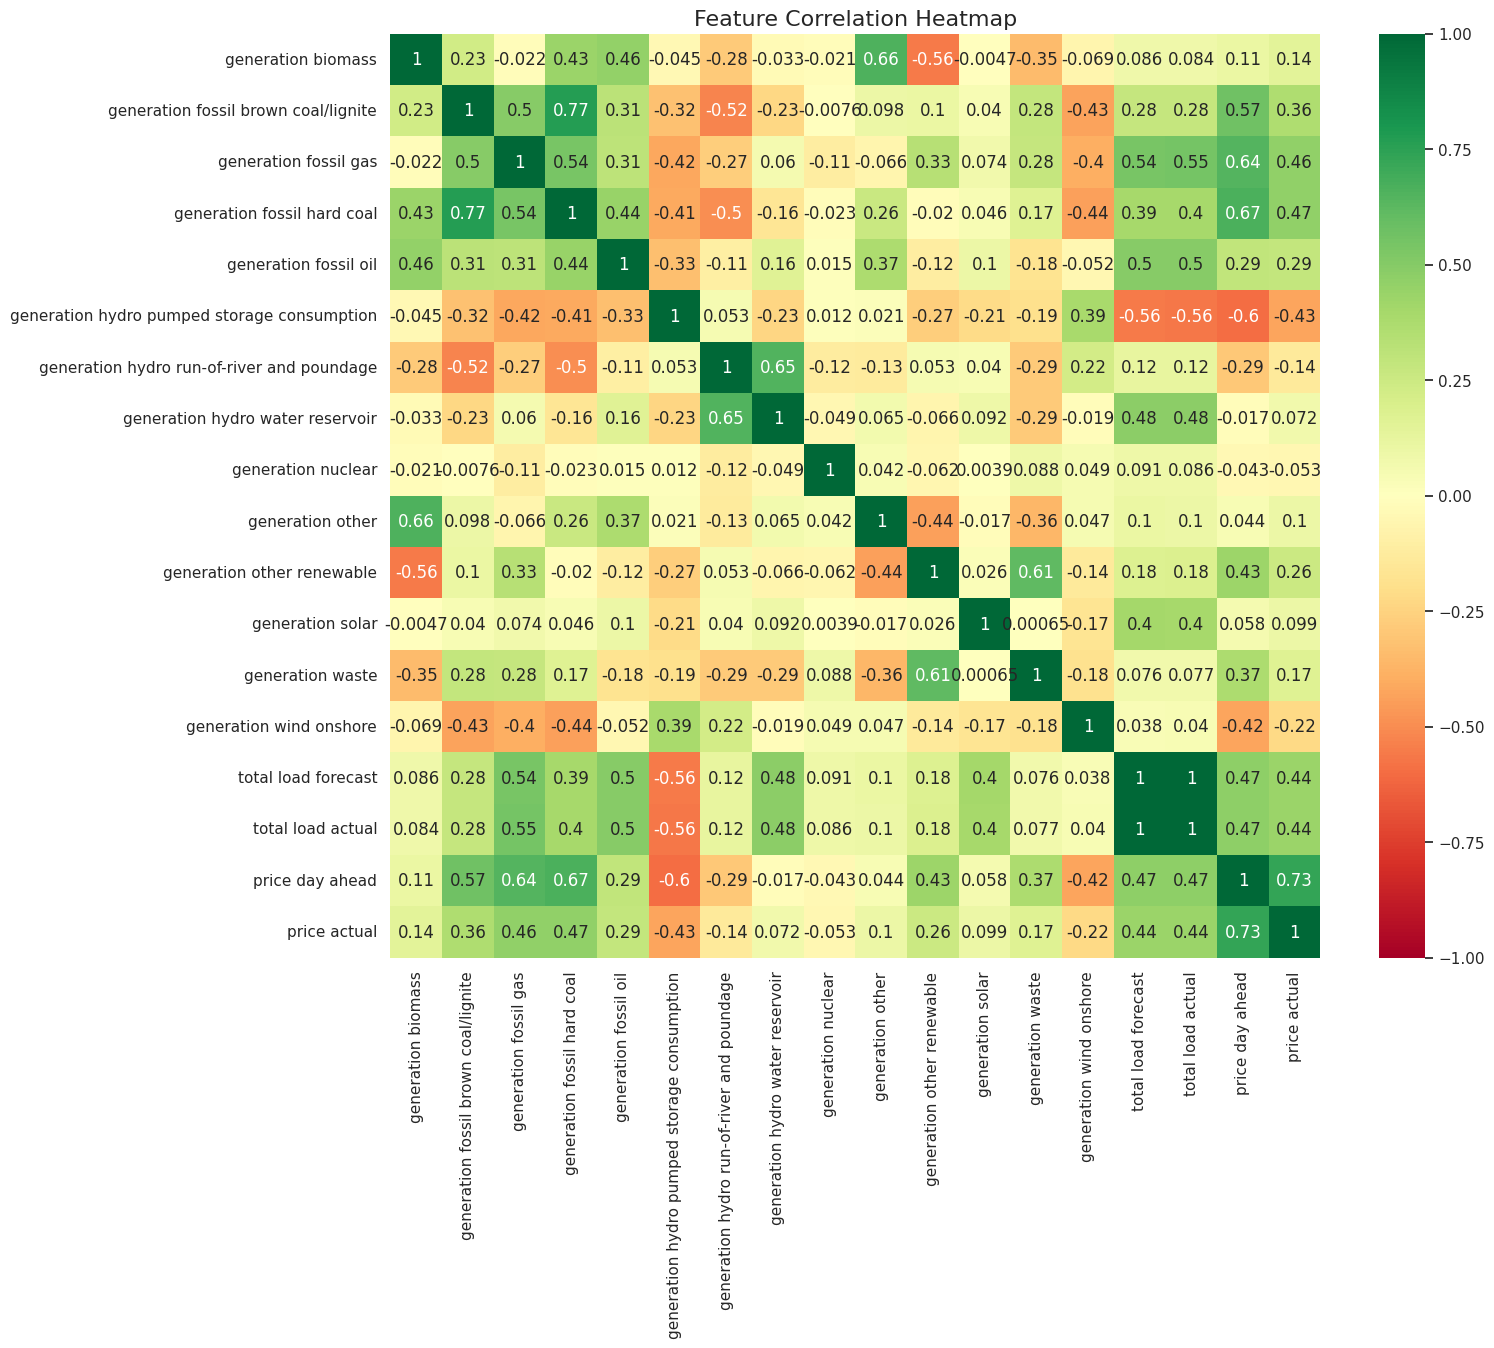

In [405]:
feat_corr(df_energy)

<h3> Weather dataset </h3>

In [407]:
# Loading weather data
df_weather = pd.read_csv('/kaggle/input/mydataset/weather_features.csv')
df_weather.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n


* Upon examining the dataframe, weather_icon appears to be an irrelevant feature.
* Features like weather_main and weather_description could influence predictions, but since we have hourly data and their effects are largely captured by the measured temperature, we can safely drop these columns. Instead, we will retain clouds_all.
* Before making final decisions on feature removal, we will review the feature correlations.


In [408]:
df_temp = df_weather.copy(deep = True)
labels = ['weather_id', 'weather_main','weather_description','weather_icon']
for col in labels:
    df_temp[col] = LabelEncoder().fit_transform(df_weather[col])


* There is a strong correlation among several features, which could lead to multicollinearity. Therefore, we will drop weather_icon, weather_main, weather_description, and weather_id, keeping only clouds_all.
* Similarly, temp, temp_min, and temp_max are highly correlated. We will retain temp and drop temp_min and temp_max.


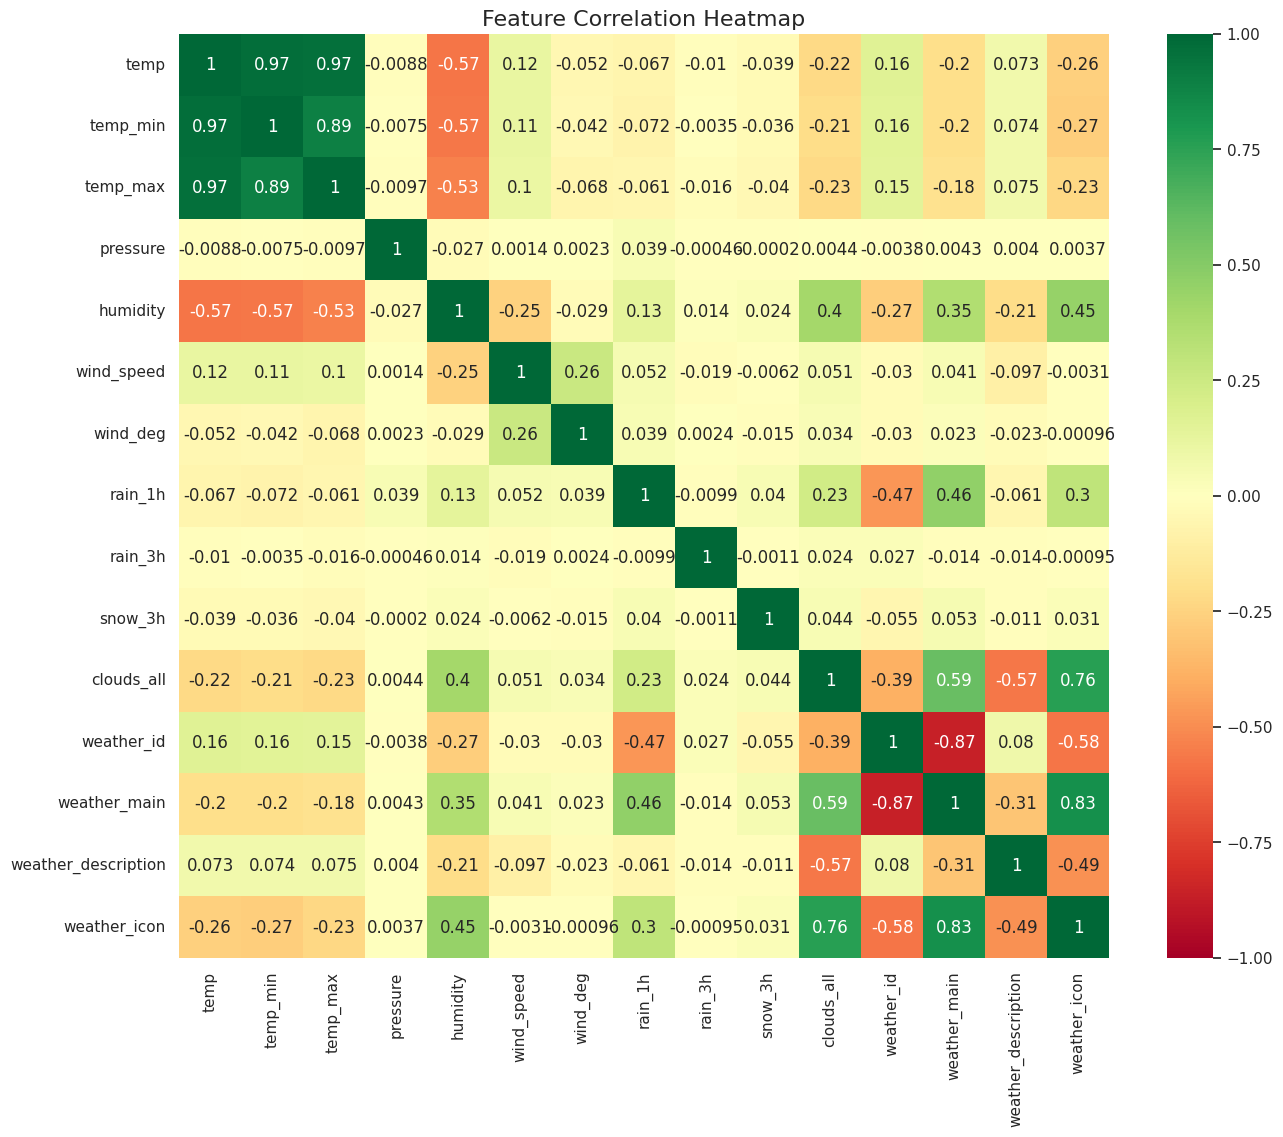

In [409]:
feat_corr(df_temp)

In [410]:
df_weather['weather_id'].unique()

array([800, 801, 802, 803, 804, 500, 501, 502, 701, 522, 521, 503, 202,
       200, 201, 211, 520, 300, 741, 301, 711, 302, 721, 310, 600, 616,
       615, 601, 210, 602, 611, 311, 612, 620, 531, 731, 761, 771])

In [411]:
col_drop_name = ['weather_id', 'weather_main','weather_description','weather_icon', 'temp_min', 'temp_max']
# col_drop_name = ['weather_id', 'weather_main','weather_description','weather_icon']
df_weather.drop(col_drop_name, axis = 1 , inplace = True)

In [412]:
check_Nans_Dups(df_weather)

Number of Nans in each column :
dt_iso        0
city_name     0
temp          0
pressure      0
humidity      0
wind_speed    0
wind_deg      0
rain_1h       0
rain_3h       0
snow_3h       0
clouds_all    0
dtype: int64

Number of duplicates in the dataframe : 3076


In [413]:
df_weather = df_weather.reset_index().drop_duplicates()

In [414]:
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'])
df_weather.drop(["dt_iso"] , axis = 1, inplace = True)
df_weather = df_weather.set_index('time')
df_weather.drop(["index"] , axis = 1, inplace = True)

/tmp/ipykernel_48/2996806199.py:1: FutureWarning:

In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`



In [415]:
df_weather

city_name     temp  pressure  humidity  wind_speed  \
time                                                                           
2015-01-01 00:00:00+01:00  Valencia  270.475      1001        77           1   
2015-01-01 01:00:00+01:00  Valencia  270.475      1001        77           1   
2015-01-01 02:00:00+01:00  Valencia  269.686      1002        78           0   
2015-01-01 03:00:00+01:00  Valencia  269.686      1002        78           0   
2015-01-01 04:00:00+01:00  Valencia  269.686      1002        78           0   
...                             ...      ...       ...       ...         ...   
2018-12-31 19:00:00+01:00   Seville  287.760      1028        54           3   
2018-12-31 20:00:00+01:00   Seville  285.760      1029        62           3   
2018-12-31 21:00:00+01:00   Seville  285.150      1028        58           4   
2018-12-31 22:00:00+01:00   Seville  284.150      1029        57           4   
2018-12-31 23:00:00+01:00   Seville  283.970      1029        70           3   

                           wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  
time                                                                        
2015-01-01 00:00:00+01:00        62      0.0      0.0      0.0           0  
2015-01-01 01:00:00+01:00        62      0.0      0.0      0.0           0  
2015-01-01 02:00:00+01:00        23      0.0      0.0      0.0           0  
2015-01-01 03:00:00+01:00        23      0.0      0.0      0.0           0  
2015-01-01 04:00:00+01:00        23      0.0      0.0      0.0           0  
...                             ...      ...      ...      ...         ...  
2018-12-31 19:00:00+01:00        30      0.0      0.0      0.0           0  
2018-12-31 20:00:00+01:00        30      0.0      0.0      0.0           0  
2018-12-31 21:00:00+01:00        50      0.0      0.0      0.0           0  
2018-12-31 22:00:00+01:00        60      0.0      0.0      0.0           0  
2018-12-31 23:00:00+01:00        50      0.0      0.0      0.0           0  

[178396 rows x 10 columns]

In [416]:
df_energy

generation biomass  generation fossil gas  \
time                                                                   
2015-01-01 00:00:00+01:00               447.0                 4844.0   
2015-01-01 01:00:00+01:00               449.0                 5196.0   
2015-01-01 02:00:00+01:00               448.0                 4857.0   
2015-01-01 03:00:00+01:00               438.0                 4314.0   
2015-01-01 04:00:00+01:00               428.0                 4130.0   
...                                       ...                    ...   
2018-12-31 19:00:00+01:00               297.0                 7634.0   
2018-12-31 20:00:00+01:00               296.0                 7241.0   
2018-12-31 21:00:00+01:00               292.0                 7025.0   
2018-12-31 22:00:00+01:00               293.0                 6562.0   
2018-12-31 23:00:00+01:00               290.0                 6926.0   

                           generation fossil oil  \
time                                               
2015-01-01 00:00:00+01:00                  162.0   
2015-01-01 01:00:00+01:00                  158.0   
2015-01-01 02:00:00+01:00                  157.0   
2015-01-01 03:00:00+01:00                  160.0   
2015-01-01 04:00:00+01:00                  156.0   
...                                          ...   
2018-12-31 19:00:00+01:00                  178.0   
2018-12-31 20:00:00+01:00                  174.0   
2018-12-31 21:00:00+01:00                  168.0   
2018-12-31 22:00:00+01:00                  163.0   
2018-12-31 23:00:00+01:00                  163.0   

                           generation hydro pumped storage consumption  \
time                                                                     
2015-01-01 00:00:00+01:00                                        863.0   
2015-01-01 01:00:00+01:00                                        920.0   
2015-01-01 02:00:00+01:00                                       1164.0   
2015-01-01 03:00:00+01:00                                       1503.0   
2015-01-01 04:00:00+01:00                                       1826.0   
...                                                                ...   
2018-12-31 19:00:00+01:00                                          1.0   
2018-12-31 20:00:00+01:00                                          1.0   
2018-12-31 21:00:00+01:00                                         50.0   
2018-12-31 22:00:00+01:00                                        108.0   
2018-12-31 23:00:00+01:00                                        108.0   

                           generation hydro run-of-river and poundage  \
time                                                                    
2015-01-01 00:00:00+01:00                                      1051.0   
2015-01-01 01:00:00+01:00                                      1009.0   
2015-01-01 02:00:00+01:00                                       973.0   
2015-01-01 03:00:00+01:00                                       949.0   
2015-01-01 04:00:00+01:00                                       953.0   
...                                                               ...   
2018-12-31 19:00:00+01:00                                      1135.0   
2018-12-31 20:00:00+01:00                                      1172.0   
2018-12-31 21:00:00+01:00                                      1148.0   
2018-12-31 22:00:00+01:00                                      1128.0   
2018-12-31 23:00:00+01:00                                      1069.0   

                           generation hydro water reservoir  \
time                                                          
2015-01-01 00:00:00+01:00                            1899.0   
2015-01-01 01:00:00+01:00                            1658.0   
2015-01-01 02:00:00+01:00                            1371.0   
2015-01-01 03:00:00+01:00                             779.0   
2015-01-01 04:00:00+01:00                             720.0   
...                                                     ...

<li> Based on stats below, we can see that there are some outliers in pressure, wind_speed and maybe rain_1h and rain_3h.
So we can see outliers in the plots. we will remove pressure and wind_speed outlier and also drop rain_3h. Becuase
rain_3h is supposed to be the amount of percipitation in the last 3 hr which should be higher than rain_1h, but the plot
does not confirm this. So we drop rain_3h. </li>

In [417]:
df_weather.describe().round(2)

temp    pressure   humidity  wind_speed   wind_deg    rain_1h  \
count  178396.00   178396.00  178396.00   178396.00  178396.00  178396.00   
mean      289.62     1069.26      68.42        2.47     166.59       0.08   
std         8.03     5969.63      21.90        2.10     116.61       0.40   
min       262.24        0.00       0.00        0.00       0.00       0.00   
25%       283.67     1013.00      53.00        1.00      55.00       0.00   
50%       289.15     1018.00      72.00        2.00     177.00       0.00   
75%       295.15     1022.00      87.00        4.00     270.00       0.00   
max       315.60  1008371.00     100.00      133.00     360.00      12.00   

         rain_3h    snow_3h  clouds_all  
count  178396.00  178396.00   178396.00  
mean        0.00       0.00       25.07  
std         0.01       0.22       30.77  
min         0.00       0.00        0.00  
25%         0.00       0.00        0.00  
50%         0.00       0.00       20.00  
75%         0.00       0.00       40.00  
max         2.32      21.50      100.00

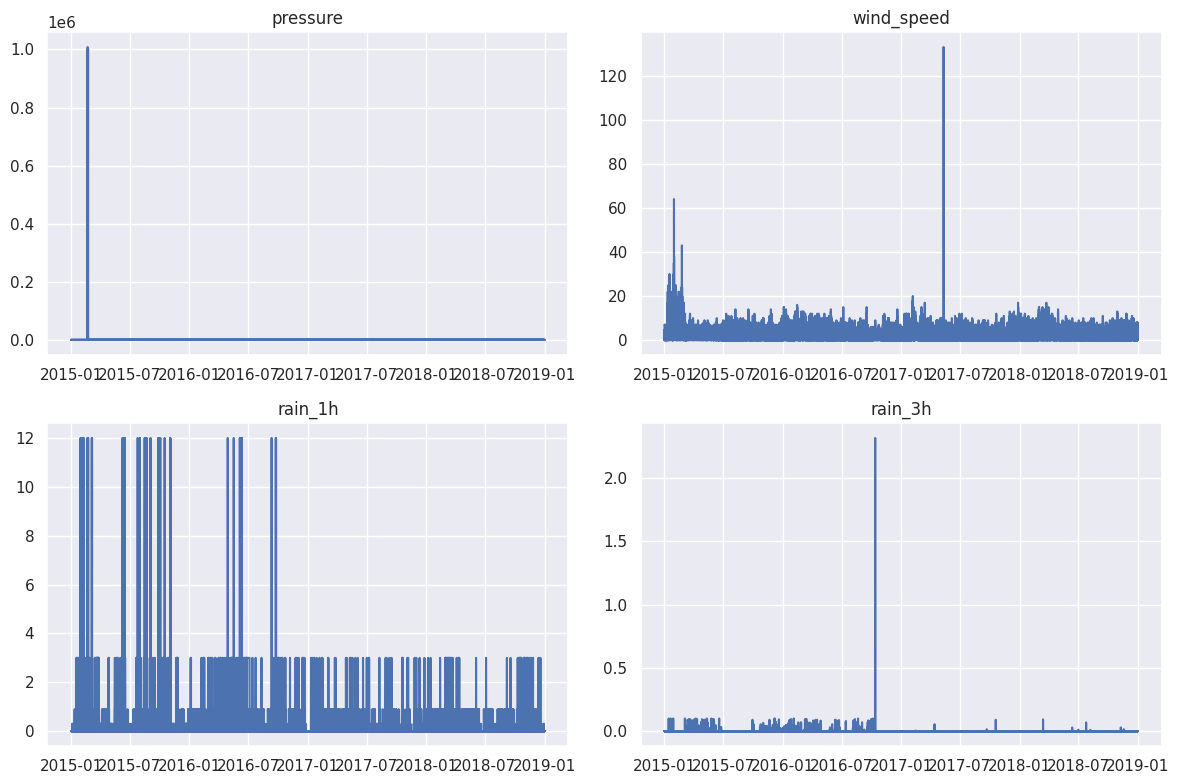

In [418]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# select the columns to plot
columns_to_plot = ['pressure', 'wind_speed', 'rain_1h', 'rain_3h']

# loop through the subplots and plot each column
for i, ax in enumerate(axes.flat):
    if i < len(columns_to_plot):
        ax.plot(df_weather.index, df_weather[columns_to_plot[i]])
        ax.set_title(columns_to_plot[i])
    else:
        ax.set_visible(False)

plt.tight_layout()  # adjust the spacing between subplots
plt.show()  # display the plot

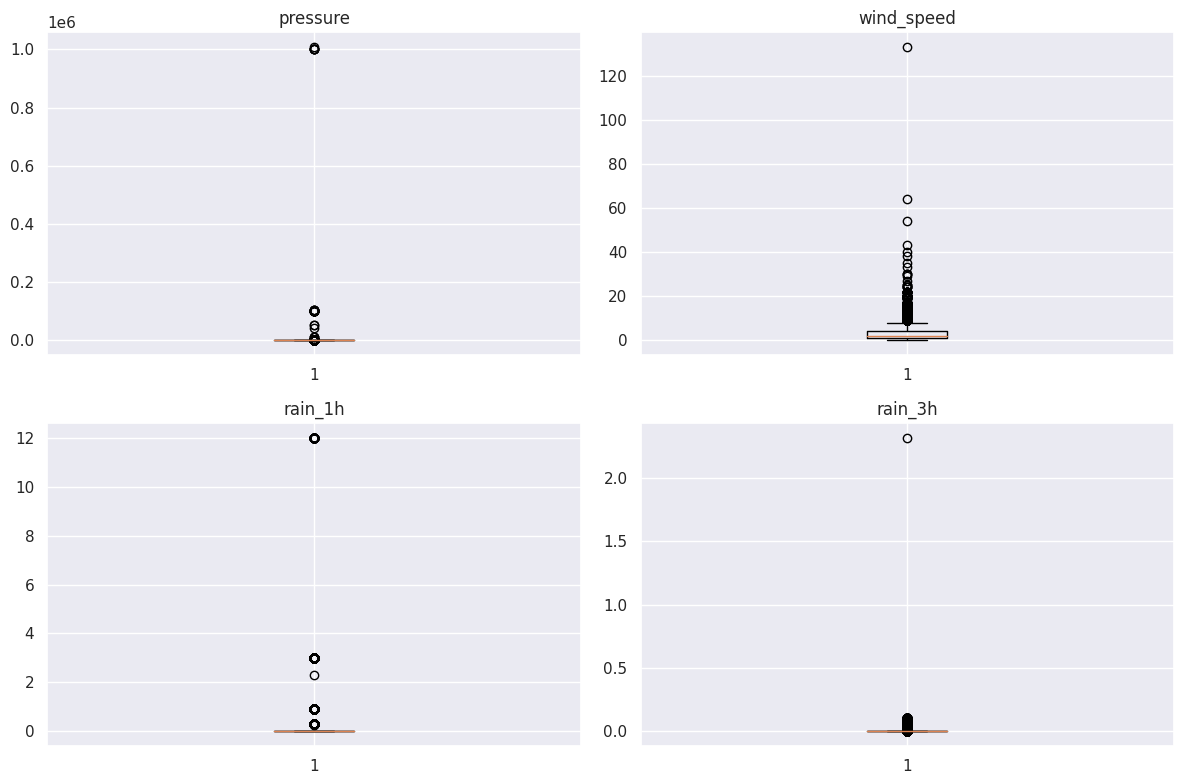

In [419]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# select the columns to plot
columns_to_plot = ['pressure', 'wind_speed', 'rain_1h', 'rain_3h']

# loop through the subplots and plot each column
for i, ax in enumerate(axes.flat):
    if i < len(columns_to_plot):
        ax.boxplot(x = df_weather[columns_to_plot[i]])
        ax.set_title(columns_to_plot[i])
    else:
        ax.set_visible(False)

plt.tight_layout()  # adjust the spacing between subplots
plt.show()  # display the plot

<p>
</p>
<li> Maximum pressure on earth is recorded as 1080hPa 
<li> Minimum pressure on earth is recorded as 870hPa 
    
<li> Maximum wind speed on earth is recorded as 113 m/s 
<p>
</p>
<li> So we set the max threshold as these numbers and replace the outliers with Nan values and then use interpolation to fill the gap. </li>        

In [420]:
df_weather.loc[df_weather['pressure']  > 1080,  'pressure'] = np.nan
df_weather.loc[df_weather['pressure']   < 870,  'pressure'] = np.nan
df_weather.loc[df_weather['wind_speed'] > 113, 'wind_speed'] = np.nan

df_weather.interpolate(method ='linear', limit_direction ='forward', inplace = True)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in less

/tmp/ipykernel_48/42852904.py:5: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



In [422]:
#  drop rain_h3
df_weather.drop(['rain_3h'], axis = 1 , inplace = True)

In [423]:
print(f'Number of samples in df_energy is {df_energy.shape[0]}')

city_list = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in city_list:
    print(f'Number of samples in df_weather in {city} is {grouped_weather.get_group(city).shape[0]}')

Number of samples in df_energy is 35064
Number of samples in df_weather in Valencia is 35145
Number of samples in df_weather in Madrid is 36267
Number of samples in df_weather in Bilbao is 35951
Number of samples in df_weather in  Barcelona is 35476
Number of samples in df_weather in Seville is 35557


In [424]:
df_weather_cleaned = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'], keep='first').set_index('time')

In [425]:
df_weather_cleaned

city_name     temp  pressure  humidity  wind_speed  \
time                                                                           
2015-01-01 00:00:00+01:00  Valencia  270.475    1001.0        77         1.0   
2015-01-01 01:00:00+01:00  Valencia  270.475    1001.0        77         1.0   
2015-01-01 02:00:00+01:00  Valencia  269.686    1002.0        78         0.0   
2015-01-01 03:00:00+01:00  Valencia  269.686    1002.0        78         0.0   
2015-01-01 04:00:00+01:00  Valencia  269.686    1002.0        78         0.0   
...                             ...      ...       ...       ...         ...   
2018-12-31 19:00:00+01:00   Seville  287.760    1028.0        54         3.0   
2018-12-31 20:00:00+01:00   Seville  285.760    1029.0        62         3.0   
2018-12-31 21:00:00+01:00   Seville  285.150    1028.0        58         4.0   
2018-12-31 22:00:00+01:00   Seville  284.150    1029.0        57         4.0   
2018-12-31 23:00:00+01:00   Seville  283.970    1029.0        70         3.0   

                           wind_deg  rain_1h  snow_3h  clouds_all  
time                                                               
2015-01-01 00:00:00+01:00        62      0.0      0.0           0  
2015-01-01 01:00:00+01:00        62      0.0      0.0           0  
2015-01-01 02:00:00+01:00        23      0.0      0.0           0  
2015-01-01 03:00:00+01:00        23      0.0      0.0           0  
2015-01-01 04:00:00+01:00        23      0.0      0.0           0  
...                             ...      ...      ...         ...  
2018-12-31 19:00:00+01:00        30      0.0      0.0           0  
2018-12-31 20:00:00+01:00        30      0.0      0.0           0  
2018-12-31 21:00:00+01:00        50      0.0      0.0           0  
2018-12-31 22:00:00+01:00        60      0.0      0.0           0  
2018-12-31 23:00:00+01:00        50      0.0      0.0           0  

[175320 rows x 9 columns]

<li> Now the number of samples in each group is the same! So we can concat weather dataframe with energy dataframe.</li>

In [426]:
print(f'Number of samples in df_energy is {df_energy.shape[0]}')

city_list = df_weather['city_name'].unique()
grouped_weather = df_weather_cleaned.groupby('city_name')

for city in city_list:
    print(f'Number of samples in df_weather in {city} is {grouped_weather.get_group(city).shape[0]}')

Number of samples in df_energy is 35064
Number of samples in df_weather in Valencia is 35064
Number of samples in df_weather in Madrid is 35064
Number of samples in df_weather in Bilbao is 35064
Number of samples in df_weather in  Barcelona is 35064
Number of samples in df_weather in Seville is 35064


In [427]:
df_weather_all_cities = [grouped_weather.get_group(x) for x in grouped_weather.groups]

In [428]:
df_weather_all_cities[0]

city_name     temp  pressure  humidity  \
time                                                                 
2015-01-01 00:00:00+01:00   Barcelona  281.625    1035.0       100   
2015-01-01 01:00:00+01:00   Barcelona  281.625    1035.0       100   
2015-01-01 02:00:00+01:00   Barcelona  281.286    1036.0       100   
2015-01-01 03:00:00+01:00   Barcelona  281.286    1036.0       100   
2015-01-01 04:00:00+01:00   Barcelona  281.286    1036.0       100   
...                               ...      ...       ...       ...   
2018-12-31 19:00:00+01:00   Barcelona  284.130    1027.0        71   
2018-12-31 20:00:00+01:00   Barcelona  282.640    1027.0        62   
2018-12-31 21:00:00+01:00   Barcelona  282.140    1028.0        53   
2018-12-31 22:00:00+01:00   Barcelona  281.130    1028.0        50   
2018-12-31 23:00:00+01:00   Barcelona  280.130    1028.0       100   

                           wind_speed  wind_deg  rain_1h  snow_3h  clouds_all  
time                                                                           
2015-01-01 00:00:00+01:00         7.0        58      0.0      0.0           0  
2015-01-01 01:00:00+01:00         7.0        58      0.0      0.0           0  
2015-01-01 02:00:00+01:00         7.0        48      0.0      0.0           0  
2015-01-01 03:00:00+01:00         7.0        48      0.0      0.0           0  
2015-01-01 04:00:00+01:00         7.0        48      0.0      0.0           0  
...                               ...       ...      ...      ...         ...  
2018-12-31 19:00:00+01:00         1.0       250      0.0      0.0           0  
2018-12-31 20:00:00+01:00         3.0       270      0.0      0.0           0  
2018-12-31 21:00:00+01:00         4.0       300      0.0      0.0           0  
2018-12-31 22:00:00+01:00         5.0       320      0.0      0.0           0  
2018-12-31 23:00:00+01:00         5.0       310      0.0      0.0           0  

[35064 rows x 9 columns]

In [429]:
df_weather_energy = df_energy

for df_city in df_weather_all_cities:
    city_name = df_city.iloc[0]['city_name'].replace(' ', '')
    df_temp_city = df_city.add_suffix(f'_{city_name}')
    df_weather_energy = pd.concat([df_weather_energy, df_temp_city], axis=1)
    df_weather_energy = df_weather_energy.drop(f'city_name_{city_name}' , axis=1)


df_weather_energy.columns

In [431]:
check_Nans_Dups(df_weather_energy)

Number of Nans in each column :
generation biomass                             0
generation fossil gas                          0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual                                   0
generation fossil total                        0
temp_Barcelona                                 0
pressure_Barcelona                             0
humidity_Barcelona                   


</p>
<li> For now, we are adding <strong>hour, weekday and month</strong> features to dataframe. These information can be helpful. For example in
shoulder seasons the heating and cooling load of all residential and commercial buildings will be low compared to summer/winter. or at the
weekend, since the office buildings are closed, the energy consumption will be lower.Regading the time, defintily energy consumption at 3 am
is way lower than the energy consumption at 10 am. So these features can be very helpful in building a good model.</li>
<p>
</p>

In [432]:
df_weather_energy['hour'] = df_weather_energy.index.map(lambda x : x.hour)
df_weather_energy['weekday'] = df_weather_energy.index.map(lambda x : x.weekday())
df_weather_energy['month'] = df_weather_energy.index.map(lambda x : x.month)
df_weather_energy['year'] = df_weather_energy.index.map(lambda x: x.year)

In [433]:
df_weather_energy.columns

Index(['generation biomass', 'generation fossil gas', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load forecast',
       'total load actual', 'price day ahead', 'price actual',
       'generation fossil total', 'temp_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'snow_3h_Barcelona', 'clouds_all_Barcelona',
       'temp_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'snow_3h_Bilbao', 'clouds_all_Bilbao', 'temp_Madrid', 'pressure_Madrid',
       'humidity_Madrid', 'wind_speed_Madrid', 'wind_deg_Madrid',
       'rain_1h_Madrid', 'snow_3h_Madri

# Visualization

In [447]:
fig = make_subplots()

fig.add_trace(
    go.Line(x=df_weather_energy.index, y=df_weather_energy["price actual"],
                                name="price actual"))
fig.add_trace(
    go.Line(x=df_weather_energy.index,y=df_weather_energy.rolling(window=24).mean()["price actual"],
                                        name="rolling window = daily ave"))
fig.add_trace(
    go.Line(x=df_weather_energy.index,y=df_weather_energy.rolling(window=24*7).mean()["price actual"],
                                        name="rolling window = weekly ave"))
# fig.update_xaxes(rangeslider_visible=True)
fig.show()

/usr/local/lib/python3.11/dist-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




<li> Based on the month bar plot, the actual price in Jan and Dec is high and on weekly daily basis,
we witness the lowest price at weekends. </li>

Text(0.5, 1.0, 'Daily actual price (0 is Monday)')

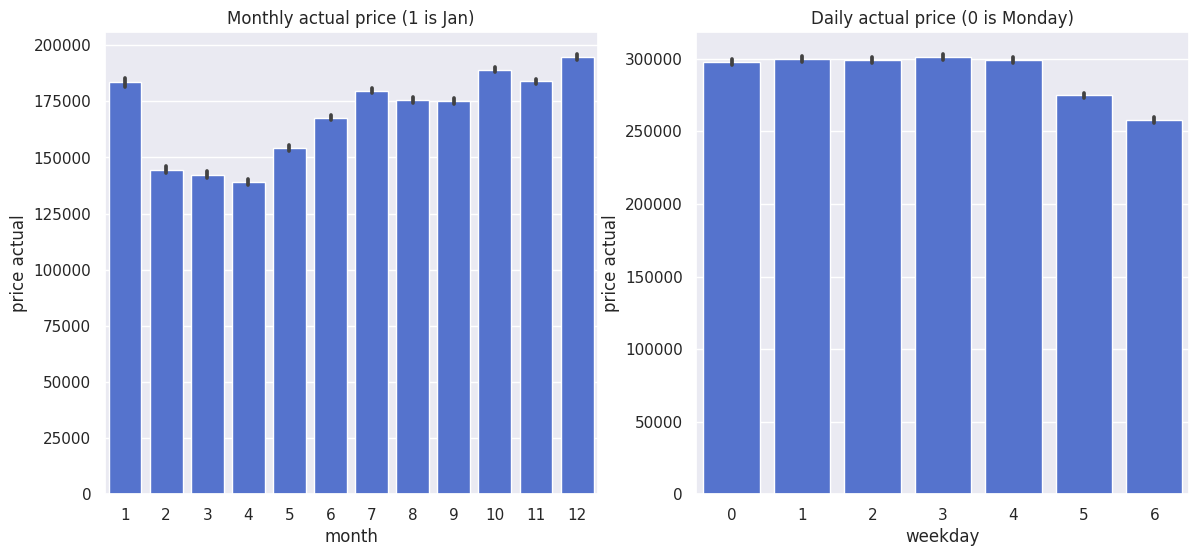

In [435]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.set(style="darkgrid")

sns.barplot(
    x="month",
    y="price actual",
    data=df_weather_energy,
    estimator=sum,
    color='royalblue',
    ax=axes[0]);
axes[0].set_title('Monthly actual price (1 is Jan)')

sns.barplot(
    x="weekday",
    y="price actual",
    data=df_weather_energy,
    estimator=sum,
    color='royalblue',
    ax=axes[1]);
axes[1].set_title('Daily actual price (0 is Monday)')


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



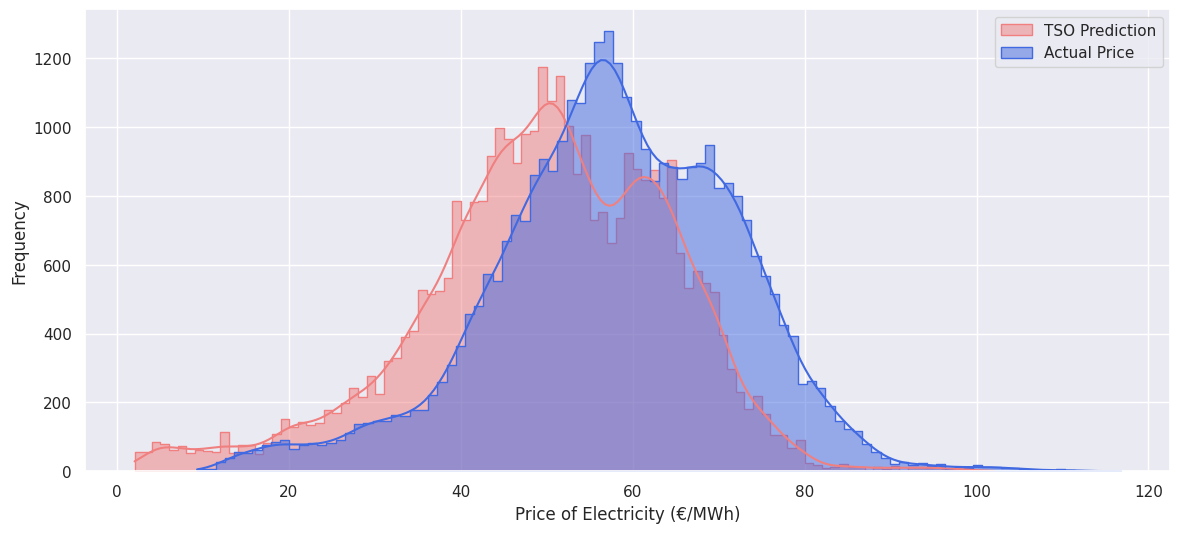

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



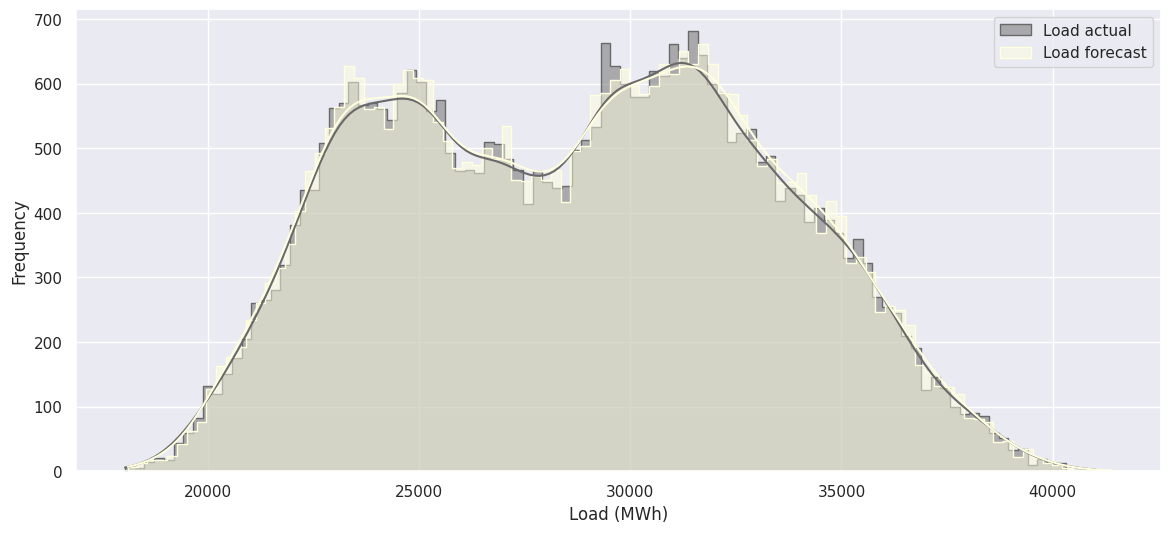

In [436]:
plt.figure(figsize=(14,6))

gr = sns.histplot(df_weather_energy['price day ahead'], bins=100, label='TSO Prediction', element="step", color='lightcoral', kde = True)
gr = sns.histplot(df_weather_energy['price actual'], bins=100, label='Actual Price', element="step", color='royalblue', kde = True)


gr.set(xlabel="Price of Electricity (€/MWh)", ylabel="Frequency")
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
gr = sns.histplot(df_weather_energy['total load actual'], bins=100, label='Load actual', element="step", color='dimgrey', kde = True)
gr = sns.histplot(df_weather_energy['total load forecast'], bins=100, label='Load forecast', element="step", color='lightyellow', kde = True)

gr.set(xlabel="Load (MWh)", ylabel="Frequency")
plt.legend()
plt.show()


* I estimated the **mean absolute error (MAE) for the normalized actual price** and TSO prediction (day-ahead price) on the test set.
* The data was normalized because the training was performed on normalized values, making the comparison consistent.
* The last 10% of the data was used as the test set, where **int(0.9 * df_weather_energy.shape[0])** represents the starting index of the test set.The resulting MAE for the TSO prediction on this test set is 0.07.


In [437]:
y_scaler_actual = MinMaxScaler()
y_scaler_dayahead = MinMaxScaler()

train_cutoff = int(0.8*df_weather_energy.shape[0])
val_cutoff = int(0.9*df_weather_energy.shape[0])

y_price_actual   = df_weather_energy[['price actual']]
y_price_dayahead = df_weather_energy[['price day ahead']]

y_scaler_actual.fit(y_price_actual[:train_cutoff])
actual_norm = y_scaler_actual.transform(y_price_actual)

y_scaler_dayahead.fit(df_weather_energy[['price day ahead']][:train_cutoff])
dayahead_norm = y_scaler_dayahead.transform(y_price_dayahead)

print(f' mean absolute error for normalized acutal price and TSO predcition is : {round(mean_absolute_error(actual_norm, dayahead_norm),3)}')

 mean absolute error for normalized acutal price and TSO predcition is : 0.071


In [438]:
df_weather_energy.drop(['total load forecast'], axis = 1, inplace = True)

<h3> Dimensionality reduction and train-test split </h3>
<p>
</p>
<li> In this section I applied PCA for dimensionality reduction and add windowing to the dataset to make it prepared as input for tensorflow. I also split the train, validation and test sets and plot it with seperate colors in the figure.
For faster convergnce and better performance of ML/DL models I normalzed the dataset. </li>

In [439]:
X = df_weather_energy.drop(['price actual'], axis = 1)
y= df_weather_energy[['price actual']]


In [440]:
def apply_PCA(X_input, cum_variance, if_apply):

    if if_apply:

        pca = PCA(n_components = cum_variance)
        # make pipeline to first standardize then apply PCA on data
        scaler_pca = make_pipeline(MinMaxScaler(), pca)
        X_pca = scaler_pca.fit(X_input).transform(X_input)

        return X_pca

    else:

        return np.array(X_input)

In [441]:
params_pca = {'cum_variance' : 0.8, 'if_apply' : True }
X_pca = apply_PCA(X, **params_pca)
X_pca.shape

(35064, 15)

In [442]:
def windowing(X_input,y_input, history_size):

    data = []
    labels = []
    for i in range(history_size, len(y_input)):
        data.append(X_input[i - history_size : i, :])
        labels.append(y_input[i])

    return np.array(data), np.array(labels).reshape(-1,1)

<li> Normalizing target varialbe, since we already normalized features during the process of applying PCA! </li>

In [443]:
train_cutoff = int(0.8*X_pca.shape[0])
val_cutoff   = int(0.9*X_pca.shape[0])

scaler_y = MinMaxScaler()
scaler_y.fit(y[:train_cutoff])
y_norm = scaler_y.transform(y)

<li> hist_size is the history size equivalent to look back! </li>

In [444]:
hist_size= 24
data_norm = np.concatenate((X_pca,y_norm), axis = 1)

X_train, y_train = windowing(data_norm[:train_cutoff,:],data_norm[:train_cutoff,-1], hist_size)
X_val, y_val     = windowing(data_norm[train_cutoff :val_cutoff,:],data_norm[train_cutoff:val_cutoff,-1], hist_size)
X_test, y_test   = windowing(data_norm[val_cutoff :,:],data_norm[val_cutoff:,-1], hist_size)

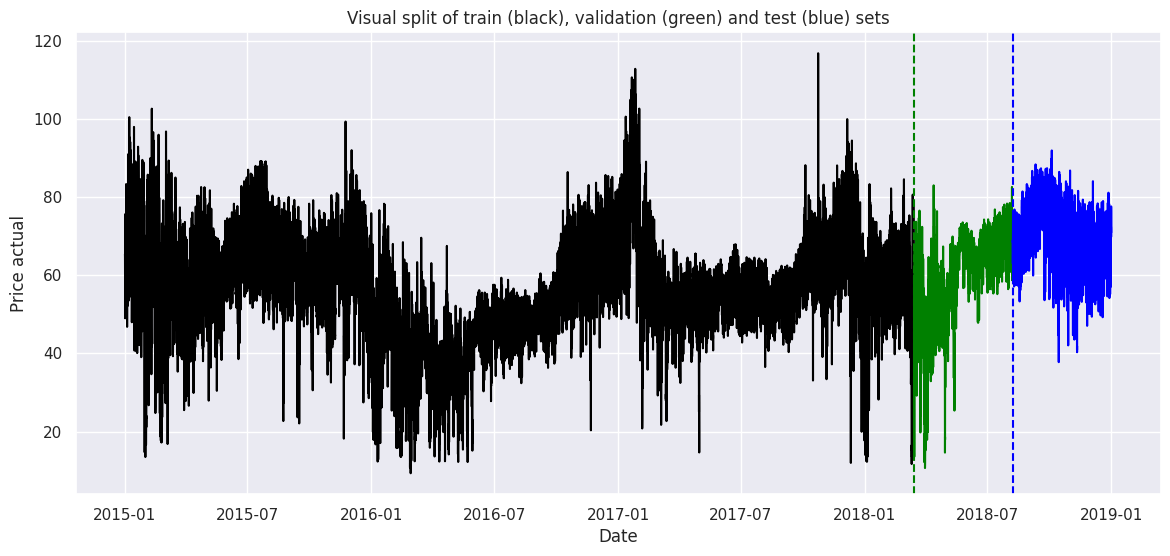

In [445]:
fig, axes = plt.subplots(figsize = (14,6))
axes.plot(df_weather_energy['price actual'].iloc[:train_cutoff], color = 'black')
axes.plot(df_weather_energy['price actual'].iloc[train_cutoff + 1 : val_cutoff], color = 'green')
axes.plot(df_weather_energy['price actual'].iloc[val_cutoff + 1 :], color = 'blue')
axes.axvline(x=df_weather_energy.index[train_cutoff], color='green', linestyle='--')
axes.axvline(x=df_weather_energy.index[val_cutoff], color='blue', linestyle='--')
axes.set_title('Visual split of train (black), validation (green) and test (blue) sets')
axes.set_xlabel('Date')
axes.set_ylabel('Price actual')
plt.show()

<h2> Forecasting Using LSTM </h2>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning:

Layer 'flatten_10' (of type Flatten) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.



Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 24, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 24, 16)    │          0 │ input_layer_6[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_4 (Masking) │ (None, 24, 16)    │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_4 (Any)         │ (None, 24)        │          0 │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 24, 132)   │     78,672 │ masking_4[0][0],  │
│                     │                   │            │ any_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 24, 1)     │        133 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 24)        │          0 │ dense_12[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 24)        │          0 │ flatten_10[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 132, 24)   │          0 │ activation_4[0][… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_4 (Permute) │ (None, 24, 132)   │          0 │ repeat_vector_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 24, 132)   │          0 │ lstm_6[0][0],     │
│ (Multiply)          │                   │            │ permute_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 3168)      │          0 │ multiply_4[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │      3,169 │ flatten_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 81,974 (320.21 KB)

 Trainable params: 81,974 (320.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - loss: 0.0897 - val_loss: 0.0528
Epoch 2/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.0364 - val_loss: 0.0443
Epoch 3/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.0300 - val_loss: 0.0277
Epoch 4/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.0244 - val_loss: 0.0183
Epoch 5/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.0207 - val_loss: 0.0155
Epoch 6/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.0187 - val_loss: 0.0151
Epoch 7/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.0177 - val_loss: 0.0147
Epoch 8/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.0175 - val_loss: 0.0135
Epoch 9/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.0170 - val_loss: 0.0147
Epoch 10/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.0165 - val_loss: 0.0146
Epoch 11/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - loss: 0.0165 - val_loss: 0.0170
Epoch 12/15
876/876 ━━━━━━━━━━

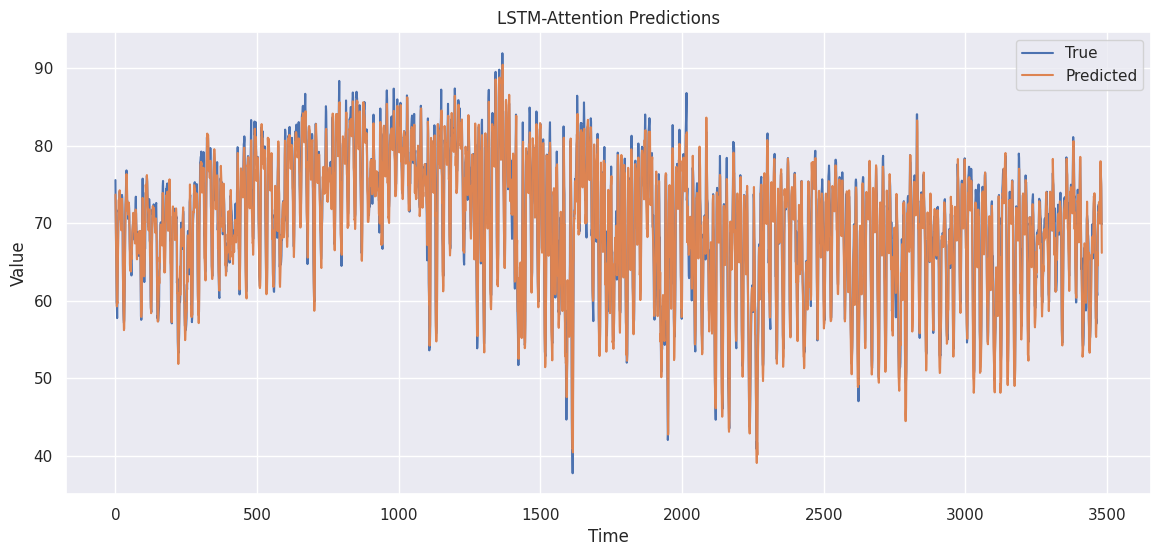

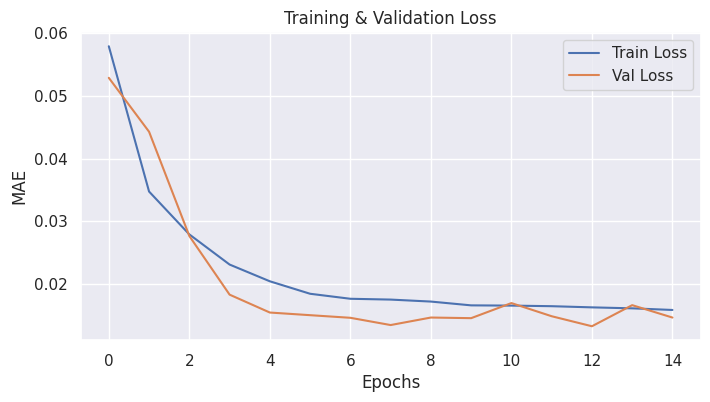

In [446]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Masking, Multiply, Permute, RepeatVector, Flatten, Activation
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def LSTM_attention(hist_size, feature_size, lstm_units=132):
    inputs = Input(shape=(hist_size, feature_size))
    
    # Masking zeros
    masked = Masking(mask_value=0.)(inputs)
    
    # LSTM
    lstm_out = LSTM(lstm_units, return_sequences=True)(masked)
    
    # Attention mechanism
    attention = Dense(1, activation='tanh')(lstm_out)   # Score for each timestep
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)        # Attention weights
    attention = RepeatVector(lstm_units)(attention)
    attention = Permute([2,1])(attention)
    
    #   Apply attention
    context = Multiply()([lstm_out, attention])
    context = Flatten()(context)
    
    # Output
    output = Dense(1)(context)
    
    model = Model(inputs=inputs, outputs=output)
    return model


#  Hyperparameters

hist_size = X_train.shape[1]     # Number of timesteps
feature_size = X_train.shape[2]  # Number of features
lstm_units = 132
epochs = 15
batch_size = 32
optimizer = 'adam'


# Compile & Train Model

LSTM_attention_model = LSTM_attention(hist_size, feature_size, lstm_units)
LSTM_attention_model.compile(optimizer=optimizer, loss='mae')
LSTM_attention_model.summary()

callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = LSTM_attention_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[callback]
)


#  Prediction

y_pred = LSTM_attention_model.predict(X_test)

# Metrics in scaled space
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print('---------------------------------------------------')
print(f'LSTM-Attention MAE (scaled): {round(mae,3)}')
print(f'LSTM-Attention RMSE (scaled): {round(rmse,3)}')
print(f'LSTM-Attention R² (scaled): {round(r2,3)}')
print('---------------------------------------------------')

# Inverse scaling (actual values)
y_pred_actual = scaler_y.inverse_transform(y_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

mae_actual = mean_absolute_error(y_test_actual, y_pred_actual)
rmse_actual = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2_actual = r2_score(y_test_actual, y_pred_actual)

print('LSTM-Attention MAE (actual scale):', round(mae_actual,3))
print('LSTM-Attention RMSE (actual scale):', round(rmse_actual,3))
print('LSTM-Attention R² (actual scale):', round(r2_actual,3))

# Plot Results
# --------------------------
def plot_results(pred, true, history, title):
    plt.figure(figsize=(14,6))
    plt.plot(true, label='True')
    plt.plot(pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
    # Training loss curve
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

plot_results(y_pred_actual, y_test_actual, history, 'LSTM-Attention Predictions')
